In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils.paths import DATA_RAW_DIR, DATA_PROCESSED_DIR

import re
import string

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import spacy

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


from wordcloud import WordCloud, STOPWORDS

In [2]:
reviews_path = DATA_RAW_DIR / "reviews.csv"
print(Path(reviews_path).exists())

True


In [3]:
df_reviews = pd.read_csv(reviews_path, sep=",", encoding="utf-8")
df_reviews.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.8+ MB


In [5]:
df_reviews.isnull().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [6]:
df_reviews.duplicated().sum()

np.int64(0)

In [7]:
df_reviews.shape

(210000, 8)

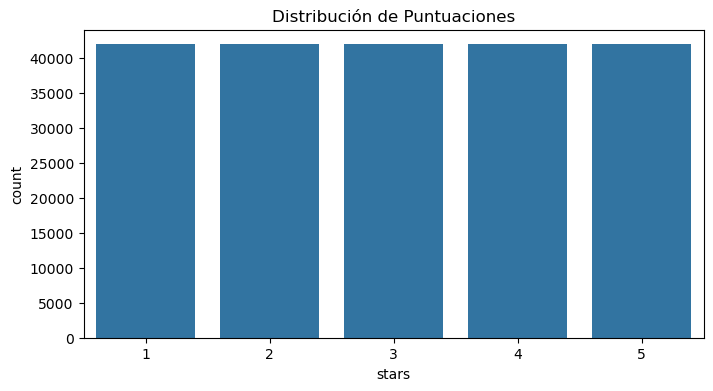

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(x='stars', data=df_reviews)
plt.title('Distribución de Puntuaciones')
plt.show()

In [9]:
df_reviews_stars = df_reviews[['review_body', 'stars']].copy()
df_reviews_stars.head()

,review_body,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,1
1,"Horrible, nos tuvimos que comprar otro porque ...",1
2,Te obligan a comprar dos unidades y te llega s...,1
3,"No entro en descalificar al vendedor, solo pue...",1
4,Llega tarde y co la talla equivocada,1


In [10]:
import re
import string

# Pre-compile regex patterns for efficiency
URL_PATTERN       = re.compile(r'https?://\S+|www\.\S+')
BRACKET_PATTERN   = re.compile(r'\[.*?\]')
HTML_TAG_PATTERN  = re.compile(r'<.*?>')
PUNCT_PATTERN     = re.compile(f"[{re.escape(string.punctuation)}]")
NUM_PATTERN       = re.compile(r'\w*\d\w*')
NON_ASCII_PATTERN = re.compile(r'[^\x00-\x7F]+')
WHITESPACE_PATTERN= re.compile(r'\s+')

def clean_text(text: str) -> str:
    # Ensure input is string
    if not isinstance(text, str):
        text = str(text)

    # 1) Normalize case
    text = text.lower()  # Convert to lowercase

    # 2) Remove unwanted patterns
    text = URL_PATTERN.sub('', text)        # Remove URLs
    text = BRACKET_PATTERN.sub('', text)    # Remove [bracketed] text
    text = HTML_TAG_PATTERN.sub('', text)   # Remove HTML tags
    text = PUNCT_PATTERN.sub('', text)      # Remove punctuation
    text = NUM_PATTERN.sub('', text)        # Remove words with digits
    text = NON_ASCII_PATTERN.sub('', text)  # Remove emojis/non-ASCII

    # 3) Normalize whitespace
    text = WHITESPACE_PATTERN.sub(' ', text)  
    text = text.strip()  # Trim leading/trailing spaces

    return text

In [11]:
df_reviews_stars['reviews_cleaned'] = df_reviews_stars['review_body'].apply(clean_text)

df_reviews_stars.head()

,review_body,stars,reviews_cleaned
0,Nada bueno se me fue ka pantalla en menos de 8...,1,nada bueno se me fue ka pantalla en menos de m...
1,"Horrible, nos tuvimos que comprar otro porque ...",1,horrible nos tuvimos que comprar otro porque n...
2,Te obligan a comprar dos unidades y te llega s...,1,te obligan a comprar dos unidades y te llega s...
3,"No entro en descalificar al vendedor, solo pue...",1,no entro en descalificar al vendedor solo pued...
4,Llega tarde y co la talla equivocada,1,llega tarde y co la talla equivocada


## Tokenizer

### NLTK

In [12]:
#customer directory
nltk.data.path.insert(0, str(DATA_RAW_DIR))

# Download punkt_tab to the custom directory
nltk.download('punkt_tab', download_dir=DATA_RAW_DIR)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jssdev/Dev/Learning/Platzi/platzi-
[nltk_data]     nlp/data/raw...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
sample_text = df_reviews_stars["reviews_cleaned"].iloc[1]
print("Text:", sample_text)

Text: horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo


In [14]:
tokens_nltk = word_tokenize(sample_text, language="spanish")
sentences_nltk = sent_tokenize(sample_text, language="spanish")

In [15]:
print("Tokens (words):")
print(tokens_nltk)
print(f"\nNumber of tokens: {len(tokens_nltk)}")

print("\n" + "="*50)

print("\nSentences:")
print(sentences_nltk)
print(f"\nNumber of sentences: {len(sentences_nltk)}")

Tokens (words):
['horrible', 'nos', 'tuvimos', 'que', 'comprar', 'otro', 'porque', 'ni', 'nosotros', 'que', 'sabemos', 'ingls', 'ni', 'un', 'informtico', 'despus', 'de', 'una', 'hora', 'fue', 'capaz', 'de', 'instalarlo']

Number of tokens: 23


Sentences:
['horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo']

Number of sentences: 1


### Spacy

In [16]:
# Load the Spanish model for Spacy
nlp_es = spacy.load('es_core_news_sm')


In [17]:
# Process the sample text with Spacy
doc_es = nlp_es(sample_text)

In [19]:
tokens_spacy = [token.text for token in doc_es]
sentences_spacy = [sent.text for sent in doc_es.sents]

In [20]:
# Print tokens and sentences
print("Tokens (words):")
print(tokens_spacy)
print(f"\nNumber of tokens: {len(tokens_spacy)}")

print("\n" + "="*50)

print("\nSentences:")
print(sentences_spacy)
print(f"\nNumber of sentences: {len(sentences_spacy)}")

Tokens (words):
['horrible', 'nos', 'tuvimos', 'que', 'comprar', 'otro', 'porque', 'ni', 'nosotros', 'que', 'sabemos', 'ingls', 'ni', 'un', 'informtico', 'despus', 'de', 'una', 'hora', 'fue', 'capaz', 'de', 'instalarlo']

Number of tokens: 23


Sentences:
['horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo']

Number of sentences: 1


In [22]:
# Download the stopwords for Spanish
nltk.download('stopwords', download_dir=DATA_RAW_DIR)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jssdev/Dev/Learning/Platzi/platzi-
[nltk_data]     nlp/data/raw...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stopword_es = set(stopwords.words('spanish'))

## Stemmer

In [28]:
stemmer_es = SnowballStemmer("spanish")

In [29]:
sample_text = df_reviews_stars["reviews_cleaned"].iloc[1]
print("Original Text:", sample_text)

Original Text: horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingls ni un informtico despus de una hora fue capaz de instalarlo


In [30]:
# Tokenize the sample text
tokens = word_tokenize(sample_text, language="spanish")
print("Tokens:", tokens)

Tokens: ['horrible', 'nos', 'tuvimos', 'que', 'comprar', 'otro', 'porque', 'ni', 'nosotros', 'que', 'sabemos', 'ingls', 'ni', 'un', 'informtico', 'despus', 'de', 'una', 'hora', 'fue', 'capaz', 'de', 'instalarlo']


In [31]:
# delete stopword_es
tokens_no_stop = [word for word in tokens if word not in stopword_es]
print("Tokens without stopwords:", tokens_no_stop)

Tokens without stopwords: ['horrible', 'comprar', 'sabemos', 'ingls', 'informtico', 'despus', 'hora', 'capaz', 'instalarlo']


In [32]:
# stem the tokens
tokens_stemmed = [stemmer_es.stem(word) for word in tokens_no_stop]
print("Stemmed Tokens:", tokens_stemmed)

Stemmed Tokens: ['horribl', 'compr', 'sab', 'ingls', 'informt', 'despus', 'hor', 'capaz', 'instal']


In [33]:
# lemmatize the tokens
doc_es = nlp_es(sample_text)
tokens_lemmatized = [token.lemma_ for token in doc_es if token.text.lower() not in stopword_es]
print("Lemmatized Tokens:", tokens_lemmatized)

Lemmatized Tokens: ['horrible', 'comprar', 'saber', 'ingls', 'informtico', 'despus', 'hora', 'capaz', 'instalar él']


In [34]:
# Compare the results
print("\nComparison of Tokenization, Stemming, and Lemmatization:")
print(f"Original Tokens: {tokens}")
print(f"Tokens without Stopwords: {tokens_no_stop}")
print(f"Stemmed Tokens: {tokens_stemmed}")
print(f"Lemmatized Tokens: {tokens_lemmatized}")


Comparison of Tokenization, Stemming, and Lemmatization:
Original Tokens: ['horrible', 'nos', 'tuvimos', 'que', 'comprar', 'otro', 'porque', 'ni', 'nosotros', 'que', 'sabemos', 'ingls', 'ni', 'un', 'informtico', 'despus', 'de', 'una', 'hora', 'fue', 'capaz', 'de', 'instalarlo']
Tokens without Stopwords: ['horrible', 'comprar', 'sabemos', 'ingls', 'informtico', 'despus', 'hora', 'capaz', 'instalarlo']
Stemmed Tokens: ['horribl', 'compr', 'sab', 'ingls', 'informt', 'despus', 'hor', 'capaz', 'instal']
Lemmatized Tokens: ['horrible', 'comprar', 'saber', 'ingls', 'informtico', 'despus', 'hora', 'capaz', 'instalar él']


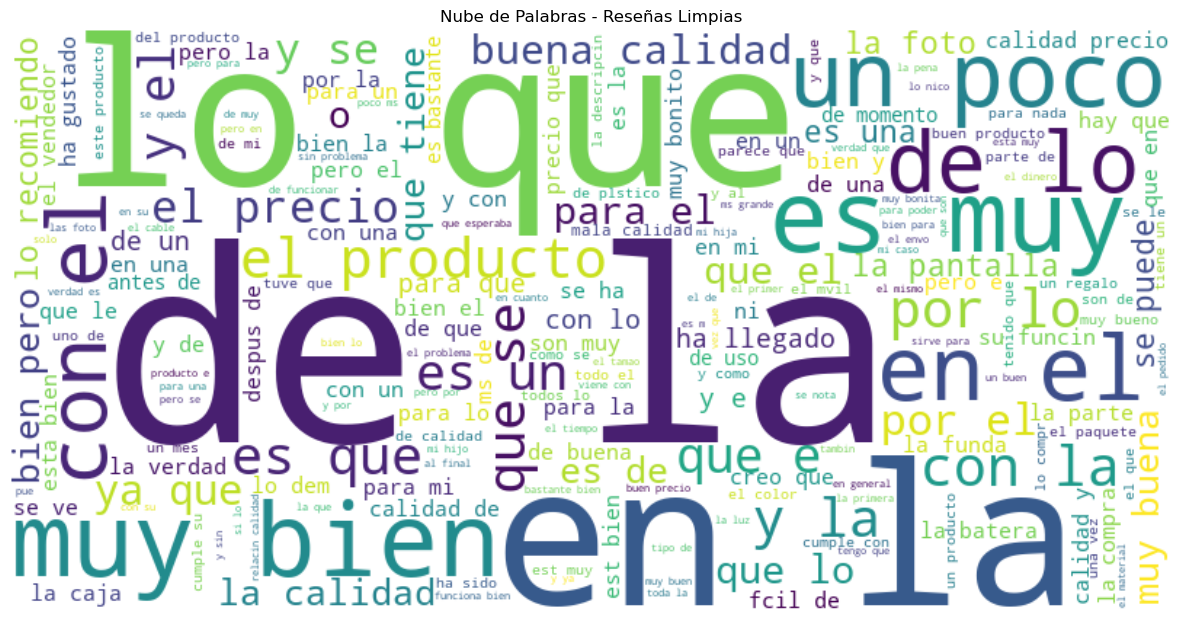

In [36]:
# clean reviews

text = " ".join(review for review in df_reviews_stars["reviews_cleaned"])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Limpias")
plt.show()

In [37]:
# wordcloud with Steemmed Tokens

def clean_with_stopwords_and_stemming(text):
    # Eliminar stopwords
    text = " ".join([word for word in text.split() if word not in stopword_es])
    # Aplicar stemming
    text = " ".join([stemmer_es.stem(word) for word in text.split()])
    # Eliminar espacios extras al inicio y final
    return text.strip()

In [38]:
df_reviews_stars["stemmed_reviews"] = df_reviews_stars["reviews_cleaned"].apply(clean_with_stopwords_and_stemming)

df_reviews_stars.head()

,review_body,stars,reviews_cleaned,stemmed_reviews
0,Nada bueno se me fue ka pantalla en menos de 8...,1,nada bueno se me fue ka pantalla en menos de m...,buen ka pantall men mes recib respuest fabric
1,"Horrible, nos tuvimos que comprar otro porque ...",1,horrible nos tuvimos que comprar otro porque n...,horribl compr sab ingls informt despus hor cap...
2,Te obligan a comprar dos unidades y te llega s...,1,te obligan a comprar dos unidades y te llega s...,oblig compr dos unidad lleg sol form reclam au...
3,"No entro en descalificar al vendedor, solo pue...",1,no entro en descalificar al vendedor solo pued...,entro descalific vendedor sol pued dec tras do...
4,Llega tarde y co la talla equivocada,1,llega tarde y co la talla equivocada,lleg tard co tall equivoc


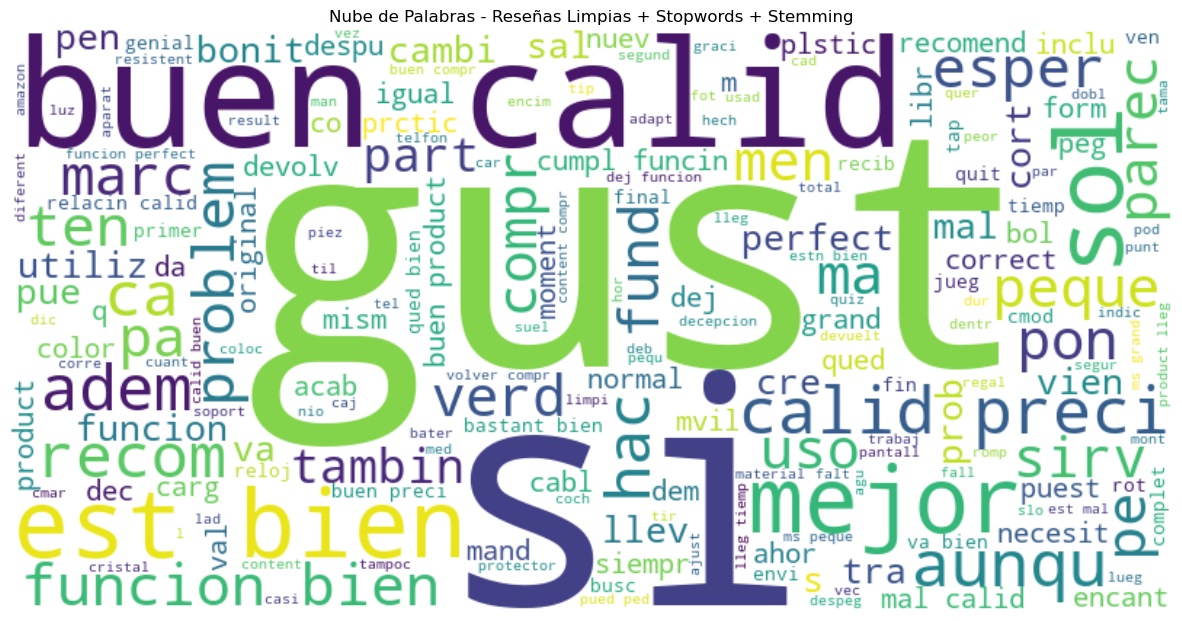

In [39]:
text = " ".join(review for review in df_reviews_stars["stemmed_reviews"])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Limpias + Stopwords + Stemming")
plt.show()

In [40]:
def clean_with_stopwords_and_lemmatization(text):
    # Procesar el texto usando spaCy
    doc = nlp_es(text)
    # Eliminar stopwords y aplicar lematización
    lemmatized = [token.lemma_ for token in doc if token.text.lower() not in stopword_es]
    # Unir los tokens lematizados y eliminar espacios extra
    return " ".join(lemmatized).strip()

In [41]:
df_reviews_stars["lemmatized_reviews"] = df_reviews_stars["reviews_cleaned"].apply(clean_with_stopwords_and_lemmatization)

df_reviews_stars.head()

,review_body,stars,reviews_cleaned,stemmed_reviews,lemmatized_reviews
0,Nada bueno se me fue ka pantalla en menos de 8...,1,nada bueno se me fue ka pantalla en menos de m...,buen ka pantall men mes recib respuest fabric,bueno ko pantallar menos mes recibir respuesta...
1,"Horrible, nos tuvimos que comprar otro porque ...",1,horrible nos tuvimos que comprar otro porque n...,horribl compr sab ingls informt despus hor cap...,horrible comprar saber ingls informtico despus...
2,Te obligan a comprar dos unidades y te llega s...,1,te obligan a comprar dos unidades y te llega s...,oblig compr dos unidad lleg sol form reclam au...,obligar comprar dos unidad llegar solo forma r...
3,"No entro en descalificar al vendedor, solo pue...",1,no entro en descalificar al vendedor solo pued...,entro descalific vendedor sol pued dec tras do...,entrar descalificar vendedor solo poder decir ...
4,Llega tarde y co la talla equivocada,1,llega tarde y co la talla equivocada,lleg tard co tall equivoc,llegar tarde co talla equivocado


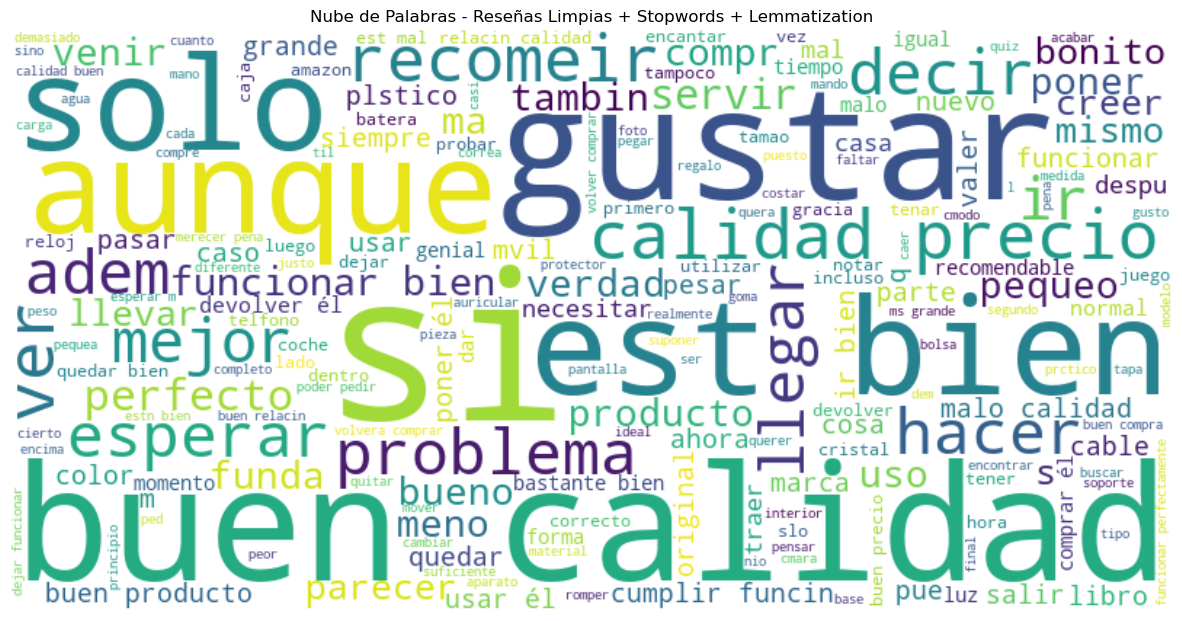

In [42]:
text = " ".join(review for review in df_reviews_stars["lemmatized_reviews"])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Limpias + Stopwords + Lemmatization")
plt.show()

In [43]:
df_reviews_stars.head()

,review_body,stars,reviews_cleaned,stemmed_reviews,lemmatized_reviews
0,Nada bueno se me fue ka pantalla en menos de 8...,1,nada bueno se me fue ka pantalla en menos de m...,buen ka pantall men mes recib respuest fabric,bueno ko pantallar menos mes recibir respuesta...
1,"Horrible, nos tuvimos que comprar otro porque ...",1,horrible nos tuvimos que comprar otro porque n...,horribl compr sab ingls informt despus hor cap...,horrible comprar saber ingls informtico despus...
2,Te obligan a comprar dos unidades y te llega s...,1,te obligan a comprar dos unidades y te llega s...,oblig compr dos unidad lleg sol form reclam au...,obligar comprar dos unidad llegar solo forma r...
3,"No entro en descalificar al vendedor, solo pue...",1,no entro en descalificar al vendedor solo pued...,entro descalific vendedor sol pued dec tras do...,entrar descalificar vendedor solo poder decir ...
4,Llega tarde y co la talla equivocada,1,llega tarde y co la talla equivocada,lleg tard co tall equivoc,llegar tarde co talla equivocado


In [45]:
df_reviews_stars[["lemmatized_reviews", "stars"]].to_csv(DATA_PROCESSED_DIR / "reviews_cleaned.csv", index=False, encoding="utf-8")